In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import numpy as np
import pandas as pd
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import HTML

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from minisom import MiniSom
from sklearn.metrics import davies_bouldin_score, normalized_mutual_info_score, homogeneity_completeness_v_measure

from typing import List

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load the dataset (LaBSE) and unify them

# Load all data
train_data = pd.read_csv("data/training_labse.csv")
test_data = pd.read_csv("data/test_labse.csv")
validation_data = pd.read_csv("data/validation_labse.csv")

# Separate X's and y's from each other
FEATURE_COLUMNS = [x for x in train_data if x.startswith("_e")]
LABEL_COLUMN = "label"

X_train = train_data[FEATURE_COLUMNS]
Y_train = train_data[LABEL_COLUMN]

X_test = test_data[FEATURE_COLUMNS]
Y_test = test_data[LABEL_COLUMN]

X_val = validation_data[FEATURE_COLUMNS]
Y_val = validation_data[LABEL_COLUMN]

# Merge them 
X = pd.concat([X_train, X_test, X_val])
Y = pd.concat([Y_train, Y_test, Y_val])

# PCA

In [3]:
# Apply PCA since the data is highly dimensional

# Perform pre-processing PCA on the training set
def perform_pca(dataset, target_variance):
    pca = PCA(n_components= target_variance)

    # Need to standardize the data frirst
    standardized = (dataset - dataset.mean(axis=0)) / dataset.std(axis = 0)

    pca.fit(X=standardized)
    dataset_reduced = pca.fit_transform(X=standardized)

    return pca, dataset_reduced

# K means Clustering

In [4]:
class KmeansResult:
    def __init__(self, k, dbi = 0, nmi = 0, hcv = (0, 0, 0)):
        self.k = k 
        self.dbi = dbi 
        self.nmi = nmi 
        self.homogeneity, self.completeness, self.v_score = hcv


In [5]:
# Apply K means to X_used
def run_search_for_k(dataset, gt, k=20):
    scores : List[KmeansResult] = []
    for n_clusters in range(2,k):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto").fit(dataset)
        labels = kmeans.labels_

        scores.append(
            KmeansResult(
                k=n_clusters,
                dbi= davies_bouldin_score(dataset, labels),
                nmi= normalized_mutual_info_score(gt, labels),
                hcv =homogeneity_completeness_v_measure(gt, labels)
            )
        )

    return scores

In [6]:
MAX_K = 20
MAX_C = X.shape[1]
true_scores = [[KmeansResult(k) for k in range(2, MAX_K)]]

for components in range(2, 10):
    pca, X_reduced = perform_pca(X, components)
    print(f"{pca.n_components_} components for training")
    
    scores = run_search_for_k(X_reduced, Y, MAX_K)
    true_scores.append(scores)

2 components for training
3 components for training
4 components for training
5 components for training
6 components for training
7 components for training
8 components for training
9 components for training


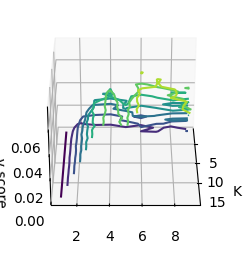

In [16]:
k_indices = np.array([k for k in range(2, MAX_K)])
pca_indices = np.array([i for i in range(1, 10)])

fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')

top = np.array([[S.v_score for S in score] for score in true_scores])
bottom = np.zeros_like(top)
width = depth = 1

xx, yy = np.meshgrid(k_indices, pca_indices)
ax1.contour(k_indices, pca_indices, top) 
ax1.set_xlabel("K")
ax1.set_ylabel("pca components")
ax1.set_zlabel("v score")

def animate(frame):
  ax1.view_init(30, frame/4)
  plt.pause(.001)
  return fig

anim = animation.FuncAnimation(fig, animate, frames=200, interval=50)
HTML(anim.to_html5_video())